In [2]:
from rouge_score import rouge_scorer
import numpy as np  
import pandas as pd 
import re       
import tensorflow as tf
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as k
k.set_learning_phase(1)
import nltk
from nltk.corpus import stopwords  
from nltk.tokenize import sent_tokenize
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.layers import Dropout, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
import keras
from tensorflow.keras import backend as k
from keras import initializers
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# 
train = pd.read_csv("./cnn_dailymail/train.csv")
train = train.loc[:150000, :]

In [4]:
train.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [5]:
# train.drop('Unnamed: 0', axis = 1, inplace = True)

In [6]:
print(train["article"].head(1).values)
print(train["highlights"].head(1).values)

["By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained

In [7]:
train.shape

(150001, 3)

In [8]:
#Removing the string "(CNN) -- "
str_to_remove = '(CNN) -- '
for i in range(len(train)):
    index = train['article'][i].find(str_to_remove)
    if index != -1:
        train['article'][i] = train['article'][i][index + len(str_to_remove):]

In [9]:
contraction_mapping = {
                       "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                       "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                       "you're": "you are", "you've": "you have"
                      }

In [10]:

for i in range(len(train)):
    for word in train['article'][i].split():
        word_lower = word.lower()
        if word_lower in contraction_mapping:
            train['article'][i] = train['article'][i].replace(word, contraction_mapping[word_lower])
    for word in train['highlights'][i].split():
        word_lower = word.lower()
        if word in contraction_mapping:
            train['highlights'][i] = train['highlights'][i].replace(word, contraction_mapping[word_lower])


In [11]:
def remove_stopwords(sent, stop):
    sent_new = " ".join([i for i in sent if i not in stop])
    return sent_new

In [12]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", 
              "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [13]:

new_article = []
new_sum = []

for i in range(len(train)):
    art_without_punc = re.sub(r'[^\w\s]','',train['article'][i])
    clean_article = [remove_stopwords(art_without_punc.split(), stop_words)]
    new_article.append(clean_article)
    
    sum_without_punc = re.sub(r'[^\w\s]','',train['highlights'][i])
    clean_sum = [remove_stopwords(sum_without_punc.split(), stop_words)]
    new_sum.append(clean_sum)

In [14]:
for i in range(len(new_article)):
    new_article[i] = str(new_article[i])[2:-2]
    new_sum[i] = str(new_sum[i])[2:-2]

In [15]:
train['new_article'] = new_article
train['new_sum'] = new_sum

In [16]:

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in range(len(train['new_article'])):
      text_word_count.append(len(train['new_article'][i].split()))

for i in range(len(train['new_sum'])):
      summary_word_count.append(len(train['new_sum'][i].split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})


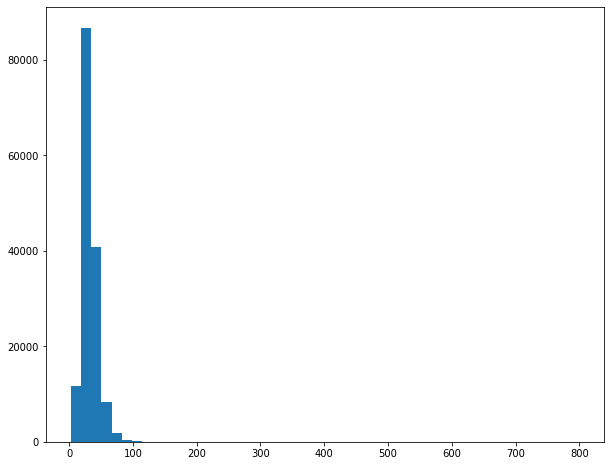

In [17]:
plt.figure(figsize = (10, 8))
plt.hist(length_df['summary'], bins = 50)
plt.show()

In [18]:
max_len_article = 1250
max_len_summary = 100

In [19]:
short_text = []
short_summary = []

for i in range(len(train)):
    if (len(train['new_article'][i].split()) <= max_len_article and len(train['new_sum'][i].split()) <= max_len_summary):
        short_text.append(train['new_article'][i])
        short_summary.append(train['new_sum'][i])

df = pd.DataFrame({"article": short_text, "summary": short_summary})

In [20]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.shape

(149828, 2)

In [21]:

X_train, X_val, y_train, y_val = train_test_split(df['article'], df['summary'], test_size = 0.1, random_state = 42, shuffle = True)

In [22]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(X_train))

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value


In [23]:
print(tot_cnt - cnt)

173044


In [24]:
VOCAB_SIZE = tot_cnt - cnt
art_tokenizer = Tokenizer(num_words= VOCAB_SIZE)
art_tokenizer.fit_on_texts(list(X_train))

X_train_seq = art_tokenizer.texts_to_sequences(X_train)
X_val_seq = art_tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(X_train_seq, maxlen = max_len_article, padding = "post", truncating = "post")
X_val = pad_sequences(X_val_seq, maxlen = max_len_article, padding = "post", truncating = "post")

X_voc_size = len(art_tokenizer.word_index) + 1
X_voc_size

494961

In [25]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

thresh= 6 

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value


In [26]:
VOCAB_SIZE_SUMM = tot_cnt - cnt
sum_tokenizer = Tokenizer(num_words = VOCAB_SIZE_SUMM)
sum_tokenizer.fit_on_texts(list(y_train))

y_train_seq = sum_tokenizer.texts_to_sequences(y_train)
y_val_seq = sum_tokenizer.texts_to_sequences(y_val)

y_train = pad_sequences(y_train_seq, maxlen = max_len_summary, padding = "post", truncating = "post")
y_val = pad_sequences(y_val_seq, maxlen = max_len_summary, padding = "post", truncating = "post")

y_voc_size = len(sum_tokenizer.word_index) + 1
y_voc_size

139839

In [27]:
EMBEDDING_DIM = 300
HIDDEN_UNITS = 400

In [28]:
encoder_inputs = Input(shape = (max_len_article, ))
encoder_embedding = Embedding(X_voc_size, EMBEDDING_DIM)(encoder_inputs)

2022-05-01 23:07:46.265599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-01 23:07:49.543982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [29]:
encoder_embedding

<KerasTensor: shape=(None, 1250, 300) dtype=float32 (created by layer 'embedding')>

In [30]:
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state = True, return_sequences = True)
encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state = True, go_backwards = True, return_sequences = True)
encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

final_h = Add()([state_h, state_h_R])
final_c = Add()([state_c, state_c_R])
encoder_outputs_final = Add()([encoder_outputs, encoder_outputs_R])
encoder_states = [final_h, final_c]

In [31]:
encoder_outputs_final

<KerasTensor: shape=(None, 1250, 400) dtype=float32 (created by layer 'add_2')>

In [32]:
decoder_inputs = Input(shape = (None,))
decoder_emb = Embedding(y_voc_size, EMBEDDING_DIM)
decoder_embedding = decoder_emb(decoder_inputs)

In [33]:
decoder_embedding

<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>

In [34]:
decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout= 0)
decoder_outputs, decoder_fwd, decoder_bwd = decoder_LSTM(decoder_embedding, initial_state = encoder_states)

In [35]:
decoder_outputs

<KerasTensor: shape=(None, None, 400) dtype=float32 (created by layer 'lstm_2')>

In [36]:
decoder_dense = TimeDistributed(Dense(y_voc_size, activation = 'softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

In [37]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1250)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1250, 300)    148488300   ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 1250, 400),  1121600     ['embedding[0][0]']              
                                 (None, 400),                                                 

In [39]:
rmsprop = RMSprop(lr = 0.001)
model.compile(optimizer = rmsprop, loss = 'sparse_categorical_crossentropy')

In [40]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

In [41]:
history = model.fit([X_train, y_train[:, :-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
                    epochs = 30, callbacks = [es], batch_size = 64,
                    validation_data = ([X_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))



Epoch 1/30


2022-05-01 23:08:04.629599: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


2107/2107 [==============================] - 1498s 705ms/step - loss: 2.6802 - val_loss: 2.4813
Epoch 2/30
2107/2107 [==============================] - 1483s 704ms/step - loss: 2.4421 - val_loss: 2.3702
Epoch 3/30
2107/2107 [==============================] - 1482s 704ms/step - loss: 2.3517 - val_loss: 2.3119
Epoch 4/30
2107/2107 [==============================] - 1481s 703ms/step - loss: 2.2922 - val_loss: 2.2717
Epoch 5/30
2107/2107 [==============================] - 1480s 702ms/step - loss: 2.2447 - val_loss: 2.2419
Epoch 6/30
2107/2107 [==============================] - 1480s 703ms/step - loss: 2.2045 - val_loss: 2.2207
Epoch 7/30
2107/2107 [==============================] - 1480s 703ms/step - loss: 2.1715 - val_loss: 2.2057
Epoch 8/30
2107/2107 [==============================] - 1479s 702ms/step - loss: 2.1396 - val_loss: 2.1906
Epoch 9/30
2107/2107 [==============================] - 1479s 702ms/step - loss: 2.1141 - val_loss: 2.1836
Epoch 10/30
2107/2107 [=========================

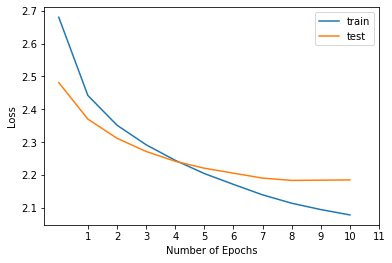

In [42]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.xticks(ticks = range(1, 12), labels = range(1, 12))
plt.legend()
plt.show()

In [43]:
reverse_sum_word_index = sum_tokenizer.index_word
reverse_art_word_index = art_tokenizer.index_word
sum_word_index = sum_tokenizer.word_index

In [44]:
encoder_model_inf = Model(inputs = encoder_inputs, outputs = [encoder_outputs_final, final_h, final_c])

decoder_state_input_h = Input(shape = (HIDDEN_UNITS, ))
decoder_state_input_c = Input(shape = (HIDDEN_UNITS, ))
decoder_hidden_state_input = Input(shape = (max_len_article, HIDDEN_UNITS))
dec_emb2 = decoder_emb(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_LSTM(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model_inf = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [45]:
def decode_seq(input):
    e_out, e_h, e_c = encoder_model_inf.predict(input)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sum_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model_inf.predict([target_seq] + [e_out, e_h, e_c])
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        try:
            sampled_token = reverse_sum_word_index[sampled_token_index]
        except KeyError:
            continue
        if sampled_token != 'eostok':
            decoded_sentence += " "+sampled_token

        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= max_len_summary - 1):
            stop_condition = True
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [46]:
def seq2seqsummary(input):
    new_string = ' '
    for i in input:
        if ((i!=0 and i!= sum_word_index['sostok']) and i!= sum_word_index['eostok']):
            try:
                new_string = new_string + reverse_sum_word_index[i] + ' '
            except KeyError:
                continue
    return new_string

def seq2seqtext(input):
    new_string = ' '
    for i in input:
        if i != 0:
            try:
                new_string = new_string + reverse_art_word_index[i] + ' '
            except KeyError:
                continue
    return new_string


In [47]:
predicted_summary = []
original_summary = []
for i in range(1000):
    pred_sum = decode_seq(X_val[i].reshape(1, max_len_article))
    orig_sum = seq2seqsummary(y_val[i])
    predicted_summary.append(pred_sum)
    original_summary.append(orig_sum)

In [48]:
df = pd.DataFrame({"Predicted": predicted_summary, "Original": original_summary})

In [49]:
df.to_csv("summary_df_0.001_64.csv")

In [51]:
score_dict = {}
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for i in range(len(df)):
    scores = scorer.score(df['Original'][i], df['Predicted'][i])
    score_dict[str(i) + '_rougeL'] = scores['rougeL']

In [52]:
precision_lst = []
recall_lst = []
f1_lst = []
for key in score_dict.keys():
    precision_lst.append(score_dict[key][0])
    recall_lst.append(score_dict[key][1])
    f1_lst.append(score_dict[key][2])

In [53]:
print("Average precision score is {}".format(sum(precision_lst)/len(precision_lst)))
print("Average recall score is {}".format(sum(recall_lst)/len(recall_lst)))
print("Average f1 score is {}".format(sum(f1_lst)/len(f1_lst)))

Average precision score is 0.1346590872002244
Average recall score is 0.10699211258150985
Average f1 score is 0.11433108175017888
